In [2]:
import statsmodels.api as sm

df_affairs = sm.datasets.fair.load().data

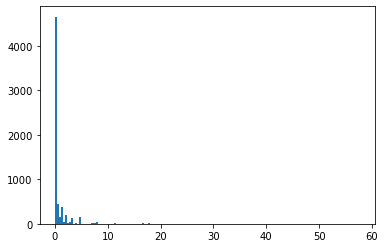

In [9]:
import matplotlib.pyplot as plt

plt.hist(df_affairs['affairs'], bins=150);

A big class imbalance typically starts at around something more extreme than 90/10. It depends on the spread of data and variance explained by input features, but the 32/68 split below is reasonable for classification.

In [3]:
total_count = df_affairs.shape[0]
positive_count = df_affairs.loc[df_affairs['affairs'] > 0].shape[0]
positive_pct = positive_count / total_count
negative_pct = 1 - positive_pct
print("Class 1 Balance: {}%".format(round(positive_pct*100, 2)))
print("Class 2 Balance: {}%".format(round(negative_pct*100, 2)))

Class 1 Balance: 32.25%
Class 2 Balance: 67.75%


Re-code the data where any value for time spent in an affair over 0 is labeled a 1. Otherwise, 0.

In [4]:
import numpy as np

df_affairs['affairs'] = np.where(df_affairs['affairs'] > 0, 1, 0)

In [5]:
X=df_affairs[['rate_marriage','age','yrs_married','children','religious','educ','occupation','occupation_husb']]
y=df_affairs['affairs']

Using the below method, we can see all input features share the same standard deviation across both target classes with the exception of rate_marriage. The standard deviation here has a difference of about 20%. Considering we have 8 input features and all features in the model will be scaled, this likely won't present an issue. If the model underperforms, based on this information, we can reasonably assume it isn't the algorithm's fault as the required assumptions are met. Rather, it would more likely be that we don't have enough features or observations to fully explain the target. We exclude 'affairs' because that's the target variable and occupation and occupation_husb because they're categorical encodings that will be one-hot encoded since we are not considering them to be ordinal based on our analysis scope.

In [131]:
df_affairs_sd = pd.concat([X, y], axis=1)

for col in df_affairs_sd.columns:
    if col not in ['affairs','occupation','occupation_husb']:
        print('Affairs = 0, Feature = {}, Standard Deviation = {}'.format(col, round(np.std(df_affairs_sd.loc[df_affairs_sd['affairs'] == 0, col]), 2)))
        print('Affairs = 1, Feature = {}, Standard Deviation = {}'.format(col, round(np.std(df_affairs_sd.loc[df_affairs_sd['affairs'] == 1, col]), 2)))

Affairs = 0, Feature = rate_marriage, Standard Deviation = 0.82
Affairs = 1, Feature = rate_marriage, Standard Deviation = 1.07
Affairs = 0, Feature = age, Standard Deviation = 6.81
Affairs = 1, Feature = age, Standard Deviation = 6.7
Affairs = 0, Feature = yrs_married, Standard Deviation = 7.1
Affairs = 1, Feature = yrs_married, Standard Deviation = 7.18
Affairs = 0, Feature = children, Standard Deviation = 1.42
Affairs = 1, Feature = children, Standard Deviation = 1.41
Affairs = 0, Feature = religious, Standard Deviation = 0.89
Affairs = 1, Feature = religious, Standard Deviation = 0.84
Affairs = 0, Feature = educ, Standard Deviation = 2.21
Affairs = 1, Feature = educ, Standard Deviation = 2.09


In the previous chapter, we identified that occupation and occupation_husb do not capture much difference in explaining affairs so we will drop occupation_husb from the dataset to minimize the volume of one-hot encodes.

In [6]:
import pandas as pd

pd.options.mode.chained_assignment = None

X['occupation'] = X['occupation'].map({1:'Occupation_One',
                                       2:'Occupation_Two',
                                       3:'Occupation_Three',
                                       4:'Occupation_Four',
                                       5:'Occupation_Five',
                                       6:'Occupation_Six'})

X = pd.get_dummies(X, columns=['occupation'])
X.drop('occupation_husb', axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
X_train_sc = X_train.copy()
X_test_sc = X_test.copy()

Here we scale all but the one-hot encoded 'occupation' variables since one-hot encodes don't scale.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

ct = ColumnTransformer([
        ('', StandardScaler(), ['rate_marriage','age','yrs_married','children','religious','educ'])
    ], remainder='passthrough')

X_train_sc = ct.fit_transform(X_train_sc)

ct = ColumnTransformer([
        ('', StandardScaler(), ['rate_marriage','age','yrs_married','children','religious','educ'])
    ], remainder='passthrough')

X_test_sc = ct.fit_transform(X_test_sc)

In [146]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_sc, y_train)

LinearDiscriminantAnalysis()

In [147]:
def precision_score(true_positives:int, false_positives:int):
    precision = true_positives / (true_positives + false_positives)

    return precision;

def recall_score(true_positives:int, false_negatives:int):
    recall = true_positives / (true_positives + false_negatives)
    
    return recall;

Precision on Train:  0.6252
Recall on Train:  0.3444


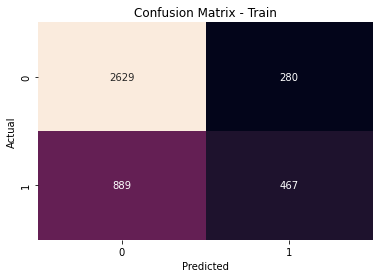

In [164]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_train_pred = lda.predict(X_train_sc)

cf_train = confusion_matrix(y_train, y_train_pred, labels=[0,1])
tn_train, fp_train, fn_train, tp_train = cf_train.ravel()

cf_matrix = sns.heatmap(cf_train, annot=True, fmt='g', cbar=False)
cf_matrix.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix - Train');

print('Precision on Train: ', round(precision_score(tp_train, fp_train), 4))
print('Recall on Train: ', round(recall_score(tp_train, fn_train), 4))

cf_matrix.figure.savefig('./train.png', dpi=300, facecolor='w')

Precision on Test:  0.6615
Recall on Test:  0.3673


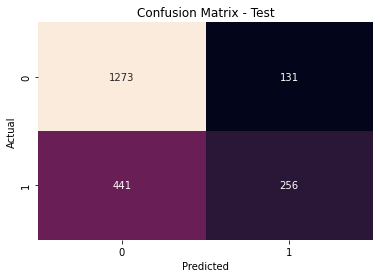

In [163]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_test_pred = lda.predict(X_test_sc)

cf_test = confusion_matrix(y_test, y_test_pred, labels=[0,1])
tn_test, fp_test, fn_test, tp_test = cf_test.ravel()

cf_matrix = sns.heatmap(cf_test, annot=True, fmt='g', cbar=False)
cf_matrix.set(xlabel='Predicted', ylabel='Actual', title='Confusion Matrix - Test');

print('Precision on Test: ', round(precision_score(tp_test, fp_test), 4))
print('Recall on Test: ', round(recall_score(tp_test, fn_test), 4))

cf_matrix.figure.savefig('./test.png', dpi=300, facecolor='w')

From these results, we can see the scores are consistent for precision and recall across both train and test set using the model we built on the training data so we can conclude the model generalizes well on unseen data compared to the benchmark (training) performance. However, the performance is not great. It is possible the issue is our target encoding is not very useful (perhaps the discretization of affairs is not useful and a statistical approach should be taken to discretize the values). However, it is also possible the features do not explain enough of the variance in the response variable to build a model that is of much use (it’s also possible affairs cannot be predicted at all and there is too much random noise to model). However, for the intent of the chapter, we were able to demonstrate how a model using LDA could be constructed and tested in addition to the preprocessing steps that must be taken before data can be modeled.

# Supervised Dimension Reduction

Unlike Principal Components Analysis (PCA), which can be used to perform unsupervised dimension reduction, LDA can be leveraged to perform supervised dimension reduction. That is, upon training the model to learn the input variance in relation to the output target, a derived set of features can be obtained.

Suppose our data produced a good result when using LDA for classification. We could then confidently use the same data to build a supervised dimension reduction technique. To perform this, we would run the following code using fit_transform() to transform the input data with respect to the target (rather than the fit() function we used to fit a classifier earlier). As with the classifier, the data should still conform to the assumptions of the LDA model. Data is reduced according to the number of classes in the response variable. Where the number of classes is C, the number of reduced features will be C-1. Because we have only two classes in our target variable, y, LDA reduces the input features to a dimension of 1.

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_reduced = lda.fit_transform(X_train_sc, y_train)

Here we can see our data is reduced from 12 features to 1:

In [16]:
print('Input data dimensions: ', X_train_sc.shape)
print('Transformed data dimensions: ', X_reduced.shape)

Input data dimensions:  (4265, 12)
Transformed data dimensions:  (4265, 1)
